<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data cleaning</a></span><ul class="toc-item"><li><span><a href="#Using-percent-served-to-convert-from-sentences-to-lengths-of-stay-(LOS)" data-toc-modified-id="Using-percent-served-to-convert-from-sentences-to-lengths-of-stay-(LOS)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Using percent served to convert from sentences to lengths of stay (LOS)</a></span></li></ul></li><li><span><a href="#Cleaning-validation" data-toc-modified-id="Cleaning-validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cleaning validation</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#OUTFLOWS-TABLES" data-toc-modified-id="OUTFLOWS-TABLES-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>OUTFLOWS TABLES</a></span></li><li><span><a href="#TRANSTIONS-TABLES" data-toc-modified-id="TRANSTIONS-TABLES-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TRANSTIONS TABLES</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

This notebook is from Fall 2021. 
It uses court data publicly available at https://virginiacourtdata.org/ to model re-implementation of parole in VA. 

The preprocessing here takes a long time, hence the option at the bottom of preprocessing to simply import the saved data from the last time you did this.

If you're going to re-run this policy, I recommend starting with the preprocessing in `parole_preprocessing` and only porting over the policy functions from this notebook.

In [2]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from shell_compartment import ShellCompartment
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# Data cleaning
Tip: you'll probably want to save the preprocessed file to a csv the first time you run this for a new policy and then import that csv from then on out to save time. To do so, uncomment the `df.to_csv()` line at the bottom of
this section, then after you run it move that file to `recidiviz-staging>recidiviz>calculator>modeling>population_projection>state>VA>VA_data`. From then on, you can skip everything in the data cleaning section and just run the file import commented out at the end of the section.

In [4]:
court_data = pd.concat([
    pd.read_csv(f'../../state/VA/VA_data/VA_jail_data/circuit_criminal_{year}_anon_00.csv') for year in range(2010,2020)
])
                      
court_data = court_data.drop(
    ['HearingJury', 'HearingPlea', 'HearingRoom', 'fips', 'Locality', 'DrivingRestrictions', 
     'RestrictionEffectiveDate', 'RestrictionEndDate', 'RestitutionPaid', 
     'RestitutionAmount', 'Military', 'TrafficFatality', 'Sex', 'Race', 'Address', 'Costs', 
     'FinesCostPaid', 'ProgramType', 'CourtDMVSurrender', 'DriverImprovementClinic', 'VAAlcoholSafetyAction', 
     'OffenseDate', 'LifeDeath', 'OperatorLicenseSuspensionTime', 'FineAmount', 'ArrestDate', 'AmendedCharge', 
     'AmendedCodeSection', 'AmendedChargeType', 'ConcludedBy', 'DispositionDate'], axis=1)
court_data = court_data[court_data.DispositionCode == 'Guilty'].drop('DispositionCode', axis=1)

court_data = court_data[(court_data.HearingResult == 'Sent') | (court_data.HearingResult == 'Sentenced')]
court_data = court_data[court_data.CodeSection.notnull()]

court_data['day'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[2]))
court_data['month'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[1]))
court_data['year'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[0]))

court_data.SentenceTime = court_data.SentenceTime.fillna(0)
court_data.SentenceSuspended = court_data.SentenceSuspended.fillna(0)
court_data['effective_sentence_months'] = (court_data.SentenceTime - court_data.SentenceSuspended) / 365 * 12
court_data = court_data[court_data.Charge.notnull() & court_data.CodeSection.notnull()]
print(f"number of records: {len(court_data)}")

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_17340/210198076.py:2: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f'../state/VA/VA_data/VA_jail_data/circuit_criminal_{year}_anon_00.csv') for year in range(2010,2020)
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_17340/210198076.py:2: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f'../state/VA/VA_data/VA_jail_data/circuit_criminal_{year}_anon_00.csv') for year in range(2010,2020)
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_17340/210198076.py:2: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f'../state/VA/VA_data/VA_jail_data/circuit_criminal_{year}_anon_00.csv') for year in range(2010,2020)
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_17340/210198076.py:2: DtypeWarning: Columns (39

number of records: 644388


## Using percent served to convert from sentences to lengths of stay (LOS)
This disaggregates by the crime types given to us in the LOS table. You may need to disaggregate differently for whatever policy you're working on, you'll have to think about how to capture the average LOS in whatever categories you work with.

In [3]:
#MURDER

murder_crime_codes = ['18.2-31', '18.2-32', '18.2-33']

first_degree_terms = ['1ST DEG', 'FIRST DEG']
capital_terms = ['CAP'] # and not 'MURDER: NON CAPITAL FELONY'
second_degree_terms = ['2ND DEG', 'SECOND DEG']

court_data['FIRST_DEGREE_MURDER'] = (
    court_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
    court_data.Charge.apply(lambda x: any([i in x for i in first_degree_terms]))
)
court_data['SECOND_DEGREE_MURDER'] = (
    court_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
    court_data.Charge.apply(lambda x: any([i in x for i in second_degree_terms]))
)
court_data['CAPITAL_MURDER'] = (
    court_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
    court_data.Charge.apply(lambda x: any([i in x for i in capital_terms]) & (x !='MURDER: NON CAPITAL FELONY'))
)
court_data['OTHER_MURDER'] = (
    court_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
    (~court_data.CAPITAL_MURDER) &
    (~court_data.FIRST_DEGREE_MURDER) &
    (~court_data.SECOND_DEGREE_MURDER)
)
#DRUG CRIMES
drug_crimes = ['18.2-248', '18.2-250', '18.2-251',  '18.2-255', '18.2-257', '18.2-258', '18.2-260', '18.2-262', 
                 '18.2-264', '18.2-265']

court_data['DRUG_POSSESSION'] = court_data.Charge.apply(
    lambda x: any([i in x for i in [
        'POSS',
        'PWID', 
    ]])
)
court_data.DRUG_POSSESSION = court_data.DRUG_POSSESSION & (
    court_data.CodeSection.apply(lambda x: any([i in x for i in drug_crimes]))
)

court_data['DRUG_SALE'] = court_data.Charge.apply(
    lambda x: any([i in x for i in [
        'DISTRB',
        'DISTRIB',
        'DIST', 
        'SALE',
        'SELL'
    ]])
)
court_data.DRUG_SALE = (court_data.DRUG_SALE) & (~court_data.DRUG_POSSESSION) & (
    court_data.CodeSection.apply(lambda x: any([i in x for i in drug_crimes]))
)

court_data['DRUG_OTHER'] = (~court_data.DRUG_SALE) & (~court_data.DRUG_POSSESSION) & (
    court_data.CodeSection.apply(lambda x: any([i in x for i in drug_crimes]))
)

#CONSPIRACY
court_data['CONSPIRACY'] = court_data.Charge.apply(
    lambda x: any([i in x for i in [
        'CONSP'
    ]])
)

# ARSON
ars_crime_codes = ['18.2-77', '18.2-79', '18.2-80',  '18.2-81', '18.2-82', '18.2-83', '18.2-84', '18.2-85', '18.2-86', 
                 '18.2-87', '18.2-88']

court_data['ARSON'] = court_data.CodeSection.apply(lambda x: any([i in x for i in ars_crime_codes]))


# SEX OFFENSE
s_crime_codes = ['18.2-346', '18.2-347', '18.2-348',  '18.2-349', '18.2-355', '18.2-356', '18.2-357', '18.2-361', 
                 '18.2-362', '18.2-365', '18.2-366', '18.2-368', '18.2-370']

court_data['SEX_OFFENSE'] = court_data.CodeSection.apply(lambda x: any([i in x for i in s_crime_codes]))

# DWIs
dwi_crime_codes = ['18.2-272', '18.2-266', '18.2-270', '46.2-341.28', '46.2-341.24', '46.2-341.26', '18.2-268', 
                   '18.2-272']

court_data['DWI'] = court_data.CodeSection.apply(lambda x: any([i in x for i in dwi_crime_codes]))

#WPN
weapons_crime_codes = ['18.2-279', '18.2-280', '18.2-281', '18.2.282', '18.2-283', '18.2-284', '18.2-285', 
                       '18.2-286', '18.2-287', '18.2-289', '18.2-290', '18.2-294', '18.2-295', '18.2-300', 
                       '18.2-304', '18.2-308', '18.2-309', '18.2-311', '18.2-312', '52-52', '53.1-203(4)',
                       '53.1-203(7)', '18.2-56.1', '18.2-56.2']

court_data['WEAPON'] = court_data.CodeSection.apply(lambda x: any([i in x for i in weapons_crime_codes]))


#BUR
burglary_crime_codes = ['18.2-93', '18.2-92', '18.2-89', '18.2-90', '18.2-91', '18.2-94']

court_data['BURGLARY'] = court_data.CodeSection.apply(lambda x: any([i in x for i in burglary_crime_codes]))


#ROB
robbery_crime_codes = ['18.2-58']
court_data['ROBBERY'] = court_data.CodeSection.apply(lambda x: any([i in x for i in robbery_crime_codes]))

# LARCENY
l_crime_codes = ['18.2-23', '18.2-95', '18.2-96',  '18.2-97', '18.2-98', '18.2-100', '18.2-101', '18.2-102', 
                 '18.2-103', '18.2-105', '18.2-107', '18.2-108',  '18.2-109', '18.2-111', '18.2-112', '18.2-113'
                '18.2-114', '18.2-115', '18.2-116', '18.2-117',  '18.2-118', '19.2-361', '18.2-113',
                '55.1-2838', '55.1-2839', '55.1-2840', '18.2-117',  '18.2-118', '18.2-178', '19.2-361']
court_data['LARCENY'] = court_data.CodeSection.apply(lambda x: any([i in x for i in l_crime_codes]))


# ASSAULT
a_crime_codes = ['18.2-41', '18.2-42', '18.2-45',  '18.2-51', '18.2-52', '18.2-53', '18.2-54', '18.2-55', '18.2-56', 
                 '18.2-57']
court_data['ASSAULT'] = court_data.CodeSection.apply(lambda x: any([i in x for i in a_crime_codes]))

# RAPE
r_crime_codes = ['18.2-61', '18.2-63', '18.2-64', '18.2-67']
court_data['RAPE'] = court_data.CodeSection.apply(lambda x: any([i in x for i in r_crime_codes]))


# KIDNAPPING
kidnapping_crime_codes = ['18.2-47', '18.2-48', '18.2-49', '18.2-50']
court_data['KIDNAPPING'] = court_data.CodeSection.apply(lambda x: any([i in x for i in kidnapping_crime_codes]))



# MANSLAUGHTER 
manslaughter_crime_codes = ['18.2-35', '18.2-36']
court_data['MANSLAUGHTER'] = court_data.CodeSection.apply(lambda x: any([i in x for i in manslaughter_crime_codes]))



In [4]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [60]:
# Uncomment either the first line to upload (if first time) or  uncomment the second line to import if 
# you've already created the table on your computer.

#court_data.to_csv('deduped_va_court_data.csv')
court_data = pd.read_csv('../../state/VA/VA_data/deduped_va_court_data.csv')

# Cleaning validation
Remaining cleaning todos:
* redo deduplication step without separating crime types then remove scale factor

In [11]:
#Check for overlap, this should be all zeros

for crime in crime_types:
    for other_crime in crime_types:
        if other_crime != crime:
            print(crime, other_crime, len(court_data[court_data[crime] & court_data[other_crime]]))

CONSPIRACY DRUG_POSSESSION 120
CONSPIRACY DRUG_SALE 485
CONSPIRACY DRUG_OTHER 346
CONSPIRACY KIDNAPPING 52
CONSPIRACY MANSLAUGHTER 5
CONSPIRACY LARCENY 761
CONSPIRACY WEAPON 13
CONSPIRACY ASSAULT 13
CONSPIRACY ROBBERY 260
CONSPIRACY BURGLARY 137
CONSPIRACY DWI 0
CONSPIRACY RAPE 3
CONSPIRACY SEX_OFFENSE 3
CONSPIRACY ARSON 4
CONSPIRACY FIRST_DEGREE_MURDER 14
CONSPIRACY SECOND_DEGREE_MURDER 1
CONSPIRACY OTHER_MURDER 19
CONSPIRACY CAPITAL_MURDER 4
DRUG_POSSESSION CONSPIRACY 120
DRUG_POSSESSION DRUG_SALE 2345
DRUG_POSSESSION DRUG_OTHER 0
DRUG_POSSESSION KIDNAPPING 0
DRUG_POSSESSION MANSLAUGHTER 0
DRUG_POSSESSION LARCENY 0
DRUG_POSSESSION WEAPON 0
DRUG_POSSESSION ASSAULT 0
DRUG_POSSESSION ROBBERY 0
DRUG_POSSESSION BURGLARY 0
DRUG_POSSESSION DWI 0
DRUG_POSSESSION RAPE 0
DRUG_POSSESSION SEX_OFFENSE 0
DRUG_POSSESSION ARSON 0
DRUG_POSSESSION FIRST_DEGREE_MURDER 0
DRUG_POSSESSION SECOND_DEGREE_MURDER 0
DRUG_POSSESSION OTHER_MURDER 0
DRUG_POSSESSION CAPITAL_MURDER 0
DRUG_SALE CONSPIRACY 485
DRUG_S

In [61]:
# This is to compare population to population in terms of breakdown in the data vs in the excel sheet
# --> they mostly line up pretty well!

LOS_data = court_data.groupby('crime_type').mean().total_sentence_months
crime_type_counts = court_data.groupby('crime_type').count().total_sentence_months
crime_type_counts * LOS_data / np.dot(crime_type_counts, LOS_data)

crime_type
ARSON                   0.005177
ASSAULT                 0.143358
BURGLARY                0.062174
CAPITAL_MURDER          0.010521
CONSPIRACY              0.003471
DRUG_OTHER              0.042558
DRUG_POSSESSION         0.090372
DRUG_SALE               0.105417
DWI                     0.021677
FIRST_DEGREE_MURDER     0.062288
KIDNAPPING              0.025742
LARCENY                 0.112850
MANSLAUGHTER            0.007296
OTHER_MURDER            0.023223
RAPE                    0.106514
ROBBERY                 0.081753
SECOND_DEGREE_MURDER    0.011254
SEX_OFFENSE             0.010185
WEAPON                  0.074170
Name: total_sentence_months, dtype: float64

In [ ]:
# Check for crime codes that aren't being caught right now...
missing = court_data[court_data.apply(lambda x: all([not x[crime] for crime in crime_types]), axis=1)]
missing.groupby('CodeSection').count().sort_values('HearingDate', ascending=False).iloc[:300]

# Preprocessing

## TODOs
* can't just drop 0 length sentences
* recidivism
* separate out jail
* total population (2019/2020 by month)
* Create a parole compartment in transitions data  
* Math for 50% of total instead of 50% of shortened sentence 

Parole specific processing

In [62]:
#What grant rate are we using to model (replace as necessary)
tn_grantrate = .24
ga_grantrate = .56
ms_grantrate = .70
wv_grantrate = .36
GRANT_RATE = (tn_grantrate + ga_grantrate + ms_grantrate + wv_grantrate) / 4
SENTENCE_REDUCTION = 0.5

#get rid of 0 length sentences
court_data = court_data[court_data.total_sentence_months > 0.5]

#make a column for class 1 felonies
court_data['C1Felony'] = ((court_data['ChargeType'] == 'Felony') & (court_data['Class'] == '1'))


#make a column for life w/o parole
LIFE_SENTENCE = 36135.0
court_data['Life'] = ((court_data['SentenceTime'] >= LIFE_SENTENCE) & (court_data['SentenceSuspended'] == 0))

#make a column marking ineligible people as False
court_data['Eligible'] = ((court_data['C1Felony'] == False) & (court_data['Life'] == False))
len(court_data.loc[court_data.Eligible == False])
#There are 914 people ineligible for parole and 185684 people eligible for parole in court_data


914

In [64]:
# We're currently missing a bunch of data that doesn't fall into any category, so we need to scale up counts 
# by the ratio of actual total data to the data we're catching
scale_factor = len(court_data) / len(court_data[court_data.crime_type.notnull()])
sorted_data = court_data[court_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)
AVERAGE_LOS = sorted_data.LOS.mean() / sorted_data.total_sentence_months.mean()

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month


<ipython-input-64-8eb10e3666e6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)


0.907324617708349

# OUTFLOWS TABLES

In [12]:
# Create outflows table
outflows_data = sorted_data.groupby(['time_step', 'Eligible']).count()[['HearingType']].reset_index().rename(
    {'HearingType': 'total_population', 'Eligible': 'crime_type'}, axis=1
)
outflows_data['crime_type'] = outflows_data['crime_type'].astype(str)
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.total_population *= scale_factor
outflows_data = outflows_data[outflows_data['time_step'] < 12]
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

,time_step,crime_type,total_population,compartment,outflow_to
0,-107,False,3.957288,pretrial,prison
1,-107,True,1618.530783,pretrial,prison
2,-106,False,6.595480,pretrial,prison
3,-106,True,1371.859832,pretrial,prison
4,-105,False,7.914576,pretrial,prison


<AxesSubplot:xlabel='time_step'>

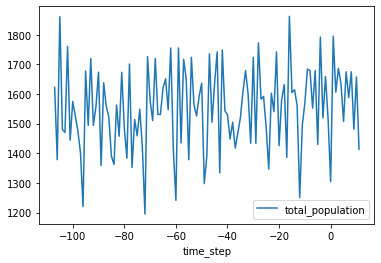

In [13]:
outflows_data.groupby('time_step').sum().plot()

# TRANSTIONS TABLES

In [36]:
# Create transitions data
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'Eligible'
]).count()[['HearingType']].reset_index().rename({
    'HearingType': 'total_population', 'Eligible': 'crime_type'
}, axis=1)
transitions_data['crime_type'] = transitions_data['crime_type'].astype(str)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'
#release to release
transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * 2,
    'total_population': [1] * 2,
    'compartment': ['release'] * 2,
    'outflow_to': ['release'] * 2,
    'crime_type': ['True', 'False']
}), ignore_index=True)

# parole 
parole_transitions = pd.DataFrame()

for _, row_data in transitions_data[
    (transitions_data.crime_type == 'True') & (transitions_data.compartment == 'prison')
].iterrows():
    if row_data.compartment_duration % 2 == 0:
        row_data.compartment_duration /= 2
        parole_transitions = parole_transitions.append(row_data, ignore_index=True)
    else:
        #split into two halves for the two compartment durations straddling n / 2
        row_data.total_population /= 2
        low = row_data.copy()
        low.compartment_duration = np.floor(low.compartment_duration / 2)
        row_data.compartment_duration = np.ceil(row_data.compartment_duration / 2)
        parole_transitions = parole_transitions.append(row_data, ignore_index=True)
        parole_transitions = parole_transitions.append(low, ignore_index=True)

parole_transitions = parole_transitions.groupby([
    'compartment_duration', 'crime_type', 'outflow_to'
], as_index=False).sum()
parole_transitions['compartment'] = 'parole'
parole_transitions = parole_transitions.append({
    'compartment_duration': 1,
    'total_population': 1,
    'compartment': 'parole',
    'outflow_to': 'release',
    'crime_type': 'False'
}, ignore_index=True)

transitions_data = transitions_data.append(parole_transitions)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

,compartment_duration,crime_type,total_population,compartment,outflow_to
0,1.0,False,184.0,prison,release
1,1.0,True,15742.0,prison,release
2,2.0,False,77.0,prison,release
3,2.0,True,8229.0,prison,release
4,3.0,False,64.0,prison,release


In [41]:
assert transitions_data[
    (transitions_data.crime_type == 'True') & (transitions_data.compartment == 'prison')
].total_population.sum() == parole_transitions.total_population.sum() - 1

In [42]:
simulation_tag = "ellie_parole"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    pd.DataFrame(),
    '../../state/VA/2022/policy_configurations/parole_model_inputs.yaml',
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Modeling

In [3]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../../state/VA/2022/policy_configurations/parole_model_inputs.yaml'
)

/Users/pacopoler/.local/share/virtualenvs/stanford-decarceration-collective-VLMPOYfe/lib/python3.8/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/pacopoler/.local/share/virtualenvs/stanford-decarceration-collective-VLMPOYfe/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1979: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(
/Users/pacopoler/.local/share/virtualenvs/stanford-d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation_factory.py:160: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for simulation_group_name, _ in transitions_data.groupby(disaggregation_axes):
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

initialization time:  9.271624088287354


/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarni

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarni

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarni

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

simulation_time:  9.778363943099976


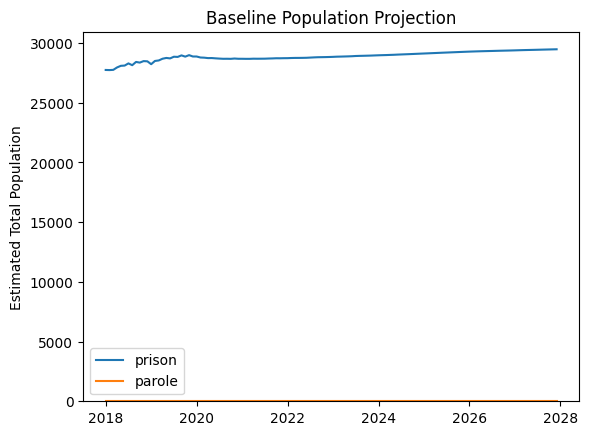

In [6]:
spark_sim.simulate_baseline(['prison','parole'])

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:312: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arima_output_df = arima_output_df.append(output_df_sub)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:312: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arima_output_df = arima_output_df.append(output_df_sub)


[<AxesSubplot: title={'center': 'compartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

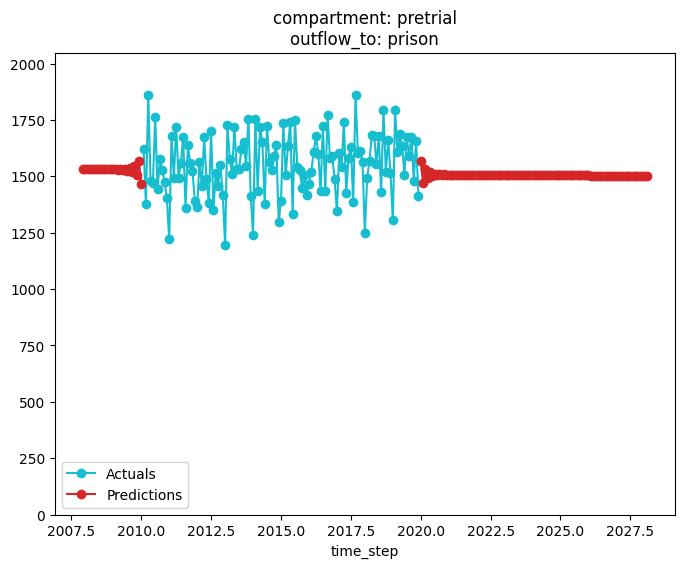

In [8]:
spark_sim.get_arima_output_plots('baseline_projections')

##Modeling todos
* actually implement policy at start of fiscal year instead of calendear year (blocked by difficulty filtering by fiscal year in google sheet pivot table)

In [11]:
GRANT_RATE = ??
SENTENCE_REDUCTION = ??
AVERAGE_LOS = ??

def parole_reallocation(): 
    return partial(TransitionTable.reallocate_outflow,
                  reallocation_df= pd.DataFrame({
                      'outflow': ['release'],
                      'affected_fraction' : [GRANT_RATE],
                      'new_outflow': ['parole']
                  }),
                reallocation_type= '+',
                retroactive= True)
    
def parole_reduction():
    return partial(TransitionTable.apply_reductions, 
                   reduction_df=pd.DataFrame({
                       'outflow': ['parole'],
                       'reduction_size': [SENTENCE_REDUCTION - (1 - AVERAGE_LOS)], 
                       'affected_fraction': [1]
                   }),
                   reduction_type='*',
                   retroactive=True)

policy_list = []
policy_list.append(SparkPolicy(policy_fn=parole_reallocation(),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': 'True'},
                                           policy_ts=36,
                                           apply_retroactive=True))

policy_list.append(SparkPolicy(policy_fn=parole_reduction(),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': 'True'},
                                           policy_ts=36,
                                           apply_retroactive=True))



test_results = spark_sim.simulate_policy(policy_list, 'prison')

NameError: name 'SENTENCE_REDUCTION' is not defined

In [66]:
# this will upload for real so don't just run it for kicks!
simulation_tag = 'ellie_parole_nov31'
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

{'spending_diff':                        prison           parole release
 year                                                  
 2018.000000               0.0              0.0     0.0
 2018.083333               0.0              0.0     0.0
 2018.166667               0.0              0.0     0.0
 2018.250000               0.0              0.0     0.0
 2018.333333               0.0              0.0     0.0
 2018.416667               0.0              0.0     0.0
 2018.500000               0.0              0.0     0.0
 2018.583333               0.0              0.0     0.0
 2018.666667               0.0              0.0     0.0
 2018.750000               0.0              0.0     0.0
 2018.833333               0.0              0.0     0.0
 2018.916667               0.0              0.0     0.0
 2019.000000               0.0              0.0     0.0
 2019.083333               0.0              0.0     0.0
 2019.166667               0.0              0.0     0.0
 2019.250000               0.0 